In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def decode_uint16_to_int4_python(bits):
    bits = bits.to(torch.int32)
    val0 = (bits >> 12) & 0xF
    val1 = (bits >> 8) & 0xF
    val2 = (bits >> 4) & 0xF
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    sign2 = (val2 & 0x8) != 0
    sign3 = (val3 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    mag2 = (val2 & 0x7).to(dtype)
    mag3 = (val3 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)
    w2 = torch.where(sign2, -mag2, mag2)
    w3 = torch.where(sign3, -mag3, mag3)

    return torch.stack([w0, w1, w2, w3], dim=-1).reshape(-1)


def decode_uint8_to_int4_python(bits):
    bits = bits.to(torch.int32) # speeds up!?
    val0 = (bits >> 4) & 0xF
    val1 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    
    dtype = torch.int8
    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)

    return torch.stack([w0, w1], dim=-1).reshape(-1)


@torch.compile()
def add(x, y, out_dtype=torch.float16):
    if x.dtype == torch.uint16:
        decoded = decode_uint16_to_int4_python(x)
    elif x.dtype == torch.uint8:
        decoded = decode_uint8_to_int4_python(x)
    else:
        raise
    return decoded + y.to(out_dtype)


torch.compile
def permute_16bits(x):
    x = x.to(torch.int32) * 34038481
    x = (x >> 9) # & 0xFFFF
    return x.to(torch.uint16)


@torch.compile()
def decode_trellis_python(bits, bits_block_size=64):
    bits = bits.reshape(-1, bits_block_size)
    even_codes = bits.view(torch.uint16)
    odd_codes = bits.roll(shifts=-1, dims=-1).view(torch.uint16)

    codes = torch.stack([even_codes, odd_codes], dim=-1).reshape(-1)

    bits = permute_16bits(codes) # << bottleneck operation
    return decode_uint16_to_int4_python(bits)


@torch.compile()
def add_trellis(x, y, out_dtype=torch.float16):
    if x.dtype == torch.uint8:
        decoded = decode_trellis_python(x)
    else:
        raise
    return decoded + y.to(out_dtype)


In [3]:
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=4, num_warps=8),


        triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=8),

        # triton.Config({'BLOCK_SIZE': 128}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 128}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 128}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 128}, num_stages=4, num_warps=8),


        # triton.Config({'BLOCK_SIZE': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 64}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 64}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 64}, num_stages=4, num_warps=8),
    ],
    key=['n_elements'],
)
@triton.jit
def add_int4_triton_uint16(bits_ptr, y_ptr, out_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)

    y_block_start = pid * BLOCK_SIZE
    y_offsets = y_block_start + 4 * tl.arange(0, BLOCK_SIZE // 4)
    y_mask = y_offsets < n_elements
    
    y0 = tl.load(y_ptr + y_offsets + 0, mask=y_mask)
    y1 = tl.load(y_ptr + y_offsets + 1, mask=y_mask)
    y2 = tl.load(y_ptr + y_offsets + 2, mask=y_mask)
    y3 = tl.load(y_ptr + y_offsets + 3, mask=y_mask)

    bits_block_start = pid * BLOCK_SIZE // 4
    bits_offsets = bits_block_start + tl.arange(0, BLOCK_SIZE // 4)
    bits_mask = bits_offsets < (n_elements // 4 + (n_elements % 4 != 0))

    bits = tl.load(bits_ptr + bits_offsets, mask=bits_mask)
    
    val0 = (bits >> 12) & 0xF 
    val1 = (bits >> 8) & 0xF 
    val2 = (bits >> 4) & 0xF 
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0 
    sign1 = (val1 & 0x8) != 0 
    sign2 = (val2 & 0x8) != 0 
    sign3 = (val3 & 0x8) != 0 
    
    dtype = tl.int16
    mag0 = (val0 & 0x7).to(dtype) 
    mag1 = (val1 & 0x7).to(dtype) 
    mag2 = (val2 & 0x7).to(dtype) 
    mag3 = (val3 & 0x7).to(dtype) 
    
    w0 = tl.where(sign0, -mag0, mag0) 
    w1 = tl.where(sign1, -mag1, mag1) 
    w2 = tl.where(sign2, -mag2, mag2) 
    w3 = tl.where(sign3, -mag3, mag3)

    tl.store(out_ptr + y_offsets + 0, w0 + y0)
    tl.store(out_ptr + y_offsets + 1, w1 + y1)
    tl.store(out_ptr + y_offsets + 2, w2 + y2)
    tl.store(out_ptr + y_offsets + 3, w3 + y3)


@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 512}, num_stages=4, num_warps=8),


        # triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=8),

        triton.Config({'BLOCK_SIZE': 128}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE': 128}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE': 128}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE': 128}, num_stages=4, num_warps=8),


        # triton.Config({'BLOCK_SIZE': 64}, num_stages=3, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 64}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 64}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 64}, num_stages=4, num_warps=8),
    ],
    key=['n_elements'],
)
@triton.jit
def add_int4_triton_uint8(bits_ptr, y_ptr, out_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)

    y_block_start = pid * BLOCK_SIZE
    y_offsets = y_block_start + 2 * tl.arange(0, BLOCK_SIZE // 2)
    y_mask = y_offsets < n_elements
    
    y0 = tl.load(y_ptr + y_offsets + 0, mask=y_mask)
    y1 = tl.load(y_ptr + y_offsets + 1, mask=y_mask)

    bits_block_start = pid * BLOCK_SIZE // 2
    bits_offsets = bits_block_start + tl.arange(0, BLOCK_SIZE // 2)
    bits_mask = bits_offsets < (n_elements // 2 + (n_elements % 2 != 0))

    bits = tl.load(bits_ptr + bits_offsets, mask=bits_mask)
    
    val0 = (bits >> 4) & 0xF 
    val1 = bits & 0xF

    sign0 = (val0 & 0x8) != 0 
    sign1 = (val1 & 0x8) != 0 
    
    dtype = tl.int16
    mag0 = (val0 & 0x7).to(dtype) 
    mag1 = (val1 & 0x7).to(dtype) 

    
    w0 = tl.where(sign0, -mag0, mag0) 
    w1 = tl.where(sign1, -mag1, mag1) 


    tl.store(out_ptr + y_offsets + 0, w0 + y0)
    tl.store(out_ptr + y_offsets + 1, w1 + y1)


@triton.jit
def add_int4_triton_v2(bits_ptr, y_ptr, out_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)

    y_block_start = pid * BLOCK_SIZE
    y_offsets = y_block_start + tl.arange(0, BLOCK_SIZE // 4)
    y_mask = y_offsets < n_elements
    
    y0 = tl.load(y_ptr + y_offsets + 0 * BLOCK_SIZE // 4, mask=y_mask)
    y1 = tl.load(y_ptr + y_offsets + 1 * BLOCK_SIZE // 4, mask=y_mask)
    y2 = tl.load(y_ptr + y_offsets + 2 * BLOCK_SIZE // 4, mask=y_mask)
    y3 = tl.load(y_ptr + y_offsets + 3 * BLOCK_SIZE // 4, mask=y_mask)

    bits_block_start = pid * BLOCK_SIZE // 4
    bits_offsets = bits_block_start + tl.arange(0, BLOCK_SIZE // 4)
    bits_mask = bits_offsets < (n_elements // 4 + (n_elements % 4 != 0))

    bits = tl.load(bits_ptr + bits_offsets, mask=bits_mask)
    
    val0 = (bits >> 12) & 0xF 
    val1 = (bits >> 8) & 0xF 
    val2 = (bits >> 4) & 0xF 
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0 
    sign1 = (val1 & 0x8) != 0 
    sign2 = (val2 & 0x8) != 0 
    sign3 = (val3 & 0x8) != 0 
    
    dtype = tl.int16
    mag0 = (val0 & 0x7).to(dtype) 
    mag1 = (val1 & 0x7).to(dtype) 
    mag2 = (val2 & 0x7).to(dtype) 
    mag3 = (val3 & 0x7).to(dtype) 
    
    w0 = tl.where(sign0, -mag0, mag0) 
    w1 = tl.where(sign1, -mag1, mag1) 
    w2 = tl.where(sign2, -mag2, mag2) 
    w3 = tl.where(sign3, -mag3, mag3)

    tl.store(out_ptr + y_offsets + 0 * BLOCK_SIZE // 4, w0 + y0)
    tl.store(out_ptr + y_offsets + 1 * BLOCK_SIZE // 4, w1 + y1)
    tl.store(out_ptr + y_offsets + 2 * BLOCK_SIZE // 4, w2 + y2)
    tl.store(out_ptr + y_offsets + 3 * BLOCK_SIZE // 4, w3 + y3)


def add_triton(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(y)
    # output = torch.empty(y.shape, dtype=torch.int16, device=y.device)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )

    if x.dtype == torch.uint16:
        assert y.shape[-1] == x.shape[-1] * 4
        add_int4_triton_uint16[grid](x, y, output, n_elements)
    elif x.dtype == torch.uint8:
        assert y.shape[-1] == x.shape[-1] * 2
        add_int4_triton_uint8[grid](x, y, output, n_elements)    
    return output


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE': 256}, num_stages=2, num_warps=2),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=2),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=2),
        
        triton.Config({'BLOCK_SIZE': 256}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=4),
        
        triton.Config({'BLOCK_SIZE': 256}, num_stages=2, num_warps=8),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE': 256}, num_stages=4, num_warps=8),
    ],
    key=['n_elements'],
)
@triton.jit
def add_int4_triton_trellis(bits_ptr, y_ptr, out_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)

    y_block_start = pid * BLOCK_SIZE
    y_offsets = y_block_start + 4 * tl.arange(0, BLOCK_SIZE // 4)
    y_mask = y_offsets < n_elements
    
    y0 = tl.load(y_ptr + y_offsets + 0, mask=y_mask)
    y1 = tl.load(y_ptr + y_offsets + 1, mask=y_mask)
    y2 = tl.load(y_ptr + y_offsets + 2, mask=y_mask)
    y3 = tl.load(y_ptr + y_offsets + 3, mask=y_mask)

    bits_block_start = pid * BLOCK_SIZE // 4
    
    offs_low = bits_block_start + tl.arange(0, BLOCK_SIZE // 4)
    offs_high = 1 + tl.arange(0, BLOCK_SIZE // 4)
    offs_high = bits_block_start + tl.where(offs_high >= BLOCK_SIZE // 4, offs_high - BLOCK_SIZE // 4, offs_high)
    bits_mask_low = offs_low < (n_elements // 2 + (n_elements % 2 != 0))
    bits_mask_high = offs_high < (n_elements // 2 + (n_elements % 2 != 0))
    
    bits_low = tl.load(bits_ptr + offs_low, mask=bits_mask_low).to(tl.uint8)
    bits_high = tl.load(bits_ptr + offs_high, mask=bits_mask_high).to(tl.uint8)
    
    codes = bits_low.to(tl.uint16) | (bits_high.to(tl.uint16) << 8)
    codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)
    
    val0 = (codes >> 12) & 0xF 
    val1 = (codes >> 8) & 0xF 
    val2 = (codes >> 4) & 0xF 
    val3 = codes & 0xF

    sign0 = (val0 & 0x8) != 0 
    sign1 = (val1 & 0x8) != 0 
    sign2 = (val2 & 0x8) != 0 
    sign3 = (val3 & 0x8) != 0 
    
    dtype = tl.int16
    mag0 = (val0 & 0x7).to(dtype) 
    mag1 = (val1 & 0x7).to(dtype) 
    mag2 = (val2 & 0x7).to(dtype) 
    mag3 = (val3 & 0x7).to(dtype) 
    
    w0 = tl.where(sign0, -mag0, mag0) 
    w1 = tl.where(sign1, -mag1, mag1) 
    w2 = tl.where(sign2, -mag2, mag2) 
    w3 = tl.where(sign3, -mag3, mag3)

    tl.store(out_ptr + y_offsets + 0, w0 + y0)
    tl.store(out_ptr + y_offsets + 1, w1 + y1)
    tl.store(out_ptr + y_offsets + 2, w2 + y2)
    tl.store(out_ptr + y_offsets + 3, w3 + y3)


def add_triton_trellis(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(y)
    # output = torch.empty(y.shape, dtype=torch.int16, device=y.device)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )


    if x.dtype == torch.uint8:
        assert y.shape[-1] == x.shape[-1] * 4
        add_int4_triton_trellis[grid](x, y, output, n_elements)    
    return output

In [4]:
torch.manual_seed(0)
size = 512 #1024 #2**20 #512

x = torch.randint(0, (2**8)-1, (size // 4,), device=DEVICE, dtype=torch.uint8)
even_codes = x.view(torch.uint16)
odd_codes = x.roll(shifts=-1).view(torch.uint16)
codes = torch.stack([even_codes, odd_codes]).T.reshape(-1)
x_unpacked = permute_16bits(codes)


y = torch.randn(size, device=DEVICE, dtype=torch.float16)
#y = torch.randint(-128, 128, (size,), device=DEVICE, dtype=torch.int8)

output_torch = add(x_unpacked, y)
output_triton = add_triton(x_unpacked, y)

output_torch_trellis = add_trellis(x, y)
output_triton_trellis = add_triton_trellis(x, y)


# print(x[:4])
# print(y[:8])
print(output_triton[:16])
print(output_torch[:16])
print(output_torch_trellis[:16])
print(output_triton_trellis[:16])
assert torch.all(output_triton == output_torch)
assert torch.all(output_torch_trellis == output_triton_trellis)

tensor([ 2.1816,  6.4492,  0.9238, -3.7344,  4.3789,  3.8672, -6.8711, -0.9404,
        -4.1875,  5.8828, -1.0137,  6.6367, -5.4883,  4.4180, -3.6895,  6.8672],
       device='cuda:0', dtype=torch.float16)
tensor([ 2.1816,  6.4492,  0.9238, -3.7344,  4.3789,  3.8672, -6.8711, -0.9404,
        -4.1875,  5.8828, -1.0137,  6.6367, -5.4883,  4.4180, -3.6895,  6.8672],
       device='cuda:0', dtype=torch.float16)
tensor([ 2.1816,  6.4492,  0.9238, -3.7344,  4.3789,  3.8672, -6.8711, -0.9404,
        -4.1875,  5.8828, -1.0137,  6.6367, -5.4883,  4.4180, -3.6895,  6.8672],
       device='cuda:0', dtype=torch.float16)
tensor([ 2.1816,  6.4492,  0.9238, -3.7344,  4.3789,  3.8672, -6.8711, -0.9404,
        -4.1875,  5.8828, -1.0137,  6.6367, -5.4883,  4.4180, -3.6895,  6.8672],
       device='cuda:0', dtype=torch.float16)


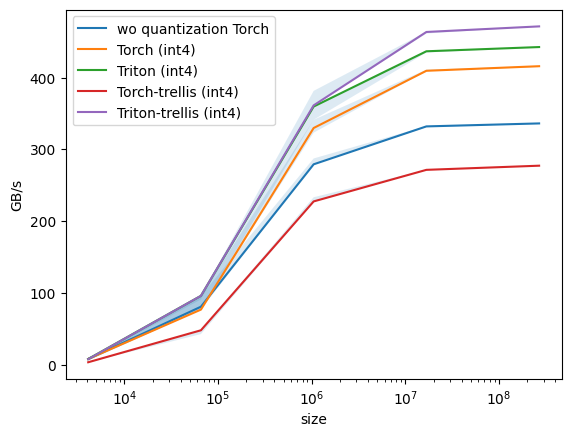

vector-add-performance:
          size  wo quantization Torch  Torch (int4)  Triton (int4)  Torch-trellis (int4)  Triton-trellis (int4)
0       4096.0               8.000000      8.000000       8.000000              3.428571               7.757576
1      65536.0              80.842109     76.800002      96.000000             48.000000              96.000000
2    1048576.0             279.272725    329.879196     359.758463            227.555555             361.411758
3   16777216.0             332.108094    409.600010     436.785344            271.558017             463.698115
4  268435456.0             336.254942    415.991545     442.680344            277.352137             471.482011


In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        #x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_vals=[2**12, 2**16, 2**20, 2**24, 2**28],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['nonquantized_torch', 'torch_int4', 'triton_int4', 'torch_trellis', 'triton_trellis'],  # Possible values for `line_arg`.
        line_names=['wo quantization Torch', 'Torch (int4)', 'Triton (int4)', 'Torch-trellis (int4)', 'Triton-trellis (int4)'],  # Label name for the lines.
        #styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.randint(0, (2**8)-1, (size // 4,), device=DEVICE, dtype=torch.uint8)
    even_codes = x.view(torch.uint16)
    odd_codes = x.roll(shifts=-1).view(torch.uint16)
    codes = torch.stack([even_codes, odd_codes]).T.reshape(-1)
    x_unpacked = permute_16bits(codes)
    x_decoded = decode_uint16_to_int4_python(x_unpacked).to(torch.float16)

    y = torch.randn(size, device=DEVICE, dtype=torch.float16)
    # y_int8 = torch.randint(-128, 128, (size,), device=DEVICE, dtype=torch.int8)
    
    quantiles = [0.5, 0.2, 0.8]
    

    if provider == 'nonquantized_torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x_decoded + y, quantiles=quantiles)
    if provider == 'torch_int4':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x_unpacked, y), quantiles=quantiles)
    if provider == 'triton_int4':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_triton(x_unpacked, y), quantiles=quantiles)
    if provider == 'torch_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_trellis(x, y), quantiles=quantiles)
    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_triton_trellis(x, y), quantiles=quantiles)


    gbps = lambda ms: 3 * y.numel() * y.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

In [6]:
8.000000
96.000000
361.411758
455.111110
462.199227

462.199227